# Machine Learning

**Representation Learning (Network Embedding)**: Task which aims to learn a mapping function *f*:*G* -> $R^n$, from discrete to continuous domain. Function *f* will be capable of performing low-dimensional vector representation such that (local and global) properties of graph *G* are preserved. <br>
Once mapping *f* is learned, it can be applied to the graph as the resulting mapping can be used as a feature set for a ML algorithm.

These can generate vector representation of nodes (**node embedding**) or edges (**edge embedding**). Which try to build a vector space such that the geometric relationships in the new space reflect the structure of the original graph, nodes or edges. So similar structures will have a small *Euclidean* distances, whilst dissimilar will have a large *Euclidean* distance. Most embedding algorithms generate mapping in Euclidean vector spaces, recent interest however has shown interest in non-Euclidean mapping functions.

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 213.10it/s]


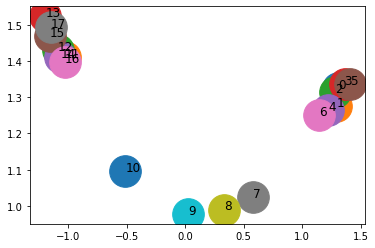

In [1]:
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

G = nx.barbell_graph(m1=7, m2=4) # generate barbell graph
# node2vec to map node to vector of two dimensions
node2vec = Node2Vec(G, dimensions=2) 
model = node2vec.fit(window=10)

# plot two-dimensional vectors of original nodes in embedding space
fig, ax = plt.subplots()
for x in G.nodes():
    v = model.wv.get_vector(str(x))
    ax.scatter(v[0], v[1], s=1000)
    ax.annotate(str(x), (v[0], v[1]), fontsize=12)

We see how good Node2Vec is at discriminating groups from each other because the algorithm uses neighbouring information of each node to generate the representation. We can clearly discriminate the two groups.

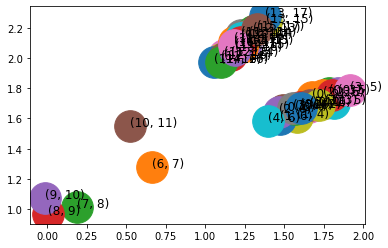

In [2]:
from node2vec.edges import HadamardEmbedder
# hadamard embedder to map edge to vector of two dimensions
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# plot on graph
fig, ax = plt.subplots()
for x in G.edges():
    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0], v[1], s=1000)
    ax.annotate(str(x), (v[0], v[1]), fontsize=12)

We can see that edge embedding identifies similar edges.

**Graph2Vec** Maps a single graph to a vector.

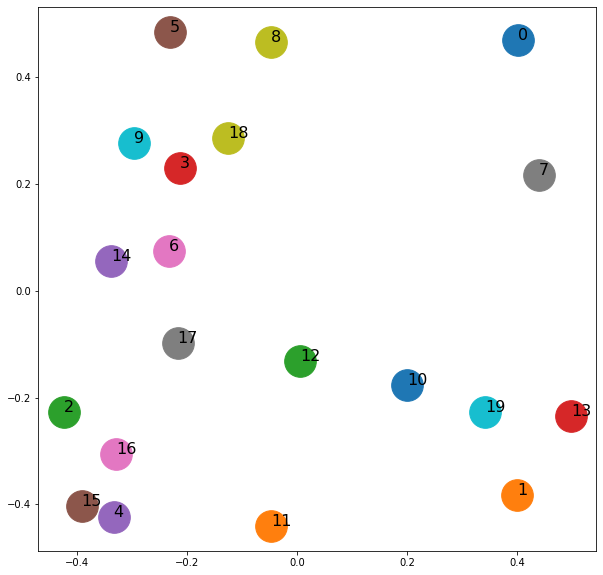

In [3]:
import random
import matplotlib.pyplot as plt
from karateclub import Graph2Vec

n_graphs = 20
def generate_random():
    n = random.randint(5, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p) # generate with random parameters

Gs = [generate_random() for x in range(n_graphs)]

# generate two-dimensional vector representation of each graph
model = Graph2Vec(dimensions=2)
model.fit(Gs)
embeddings = model.get_embedding()

# plot generated vectors in Euclidean space
fig, ax = plt.subplots(figsize=(10,10))
for i, vec in enumerate(embeddings):
    ax.scatter(vec[0], vec[1], s=1000)
    ax.annotate(str(i), (vec[0], vec[1]), fontsize=16)

Various methods of node embeddings, typically two main types:
-  **Transductive**: If new nodes are provided, transductive methods update the model (eg. re-train) to infer new information about the nodes 
-  **Inductive**: Expected to generalize to new nodes, edges, or graphs that were not observed during training


At some point, a common taxonomy was defined, https://arxiv.org/abs/2005.03675, under which we have two fundamental concepts:
-  **Encoder(ENC)**: Maps input to embedding space
-  **Decoder(DEC)**: Decodes structural information about graph from learned embedding

The idea is that: If we can encode a graph such that the decoder can retrieve all the necessary information, then the embedding must contain a compressed version of the information and thus can be used for downstream ML tasks. In many graph-based ML algorithms, the decoder is usually designed to map pairs of node embeddings to a real value, usually representing the proximity (distance) of nodes in the original graphs. We may be able to get embedding representation DEC(zi, zj) = 1 if in the input graph an edge connecting the two nodes zi, zj exists. In practice, more effective proximity functions can be used to measure the similarity between nodes.

### Categorisation of Embedding Algorithms:
- **Shallow embedding methods**: Can learn and return embedding values for learned input data, *Node2Vec, Edge2Vec, Graph2Vec* are examples. Can only obtain embedding vector for data seen during thefit procedure. 
```py
model.fit(graphs_list) # trained on list of graphs
emedding = model.get_embedding()[i] # embedding of ith graph
```
-  **Graph autoencoding methods**: Learn a more general mapping function, *f(G)* capable of also generating embedding vector for unseen instances.
```py
model.fit(graphs_list)
embedding = model.get_embedding(G) # able to generate embedding for new unseen graph G
```
-  **Neighbourhood Aggregation methods**: Can be used to extract embeddings at the graph level where nodes are labeled with some properties. Able to learn general mapping function *f(G)* capable of generating embedding vector for unseen instances. 


With the above algorithms, we can build an embedding space that takes into account **internal** structure and **external** information, defined as properties of nodes. Also with this method, we can have an embedding space to help identify graphs with similar structures and different properties on nodes.

-  **Graph Regularisation methods**: Do not have graph as an input, instead objective is to learn from a set of features by exploiting their *interaction* to regularise the process. Can construct a graph by considering feature similarities. Based on the assumption that nearby nodes are likely to have the same labels. Therefore, loss unction designed to constrain labels to be consistent with graph structure. E.g. Regularization may constrain neighbouring nodes to share similar embeddings, n terms of their distance in L2 norm. For this reason, the encoder uses X node features as input. <br>
These graphs belong to a family that learns function *f(X)* that maps a specific set of features (X) to an embedding vector and is able to apply learned function tonew, unseen features.


Here we can define *unsupervised* and *supervised* versions. e.g. graph autoencoding methods are suitable in unsupervised tasks, whilst graph regularisation for semi-supervised/supervised settings.
